In [1]:
import numpy as np
np.random.seed(1001)
import os
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#Reading csv file
train = pd.read_csv("../Environment sound classification/meta/dataset.csv")

In [3]:
train.head()

,filename,fold,target,category,src_file,take
0,1-100032-A-0.wav,1,0,dog,100032,A
1,1-110389-A-0.wav,1,0,dog,110389,A
2,1-116765-A-41.wav,1,41,chainsaw,116765,A
3,1-17150-A-12.wav,1,12,crackling_fire,17150,A
4,1-172649-A-40.wav,1,40,helicopter,172649,A


In [4]:
train.category.unique()

array(['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain',
       'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves'],
      dtype=object)

In [5]:
print('Minimum samples per category = ', min(train.category.value_counts()))
print('Maximum samples per category = ', max(train.category.value_counts()))

Minimum samples per category =  40
Maximum samples per category =  40


In [6]:
# play a sample from sound data 
import IPython.display as ipd  
fname = "../Environment sound classification/audio/" + '5-234879-A-1.wav'
ipd.Audio(fname)

In [7]:
# Properties of the sample using wave library
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration of sound = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  220500
Duration of sound =  5.0


In [8]:
# Using scipy to extract data to array of sample
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (220500,)
[ -27  -78 -110 ...    0    0    0]


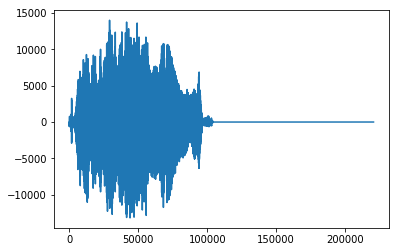

In [9]:
#visualisation of a singal wave
plt.plot(data)

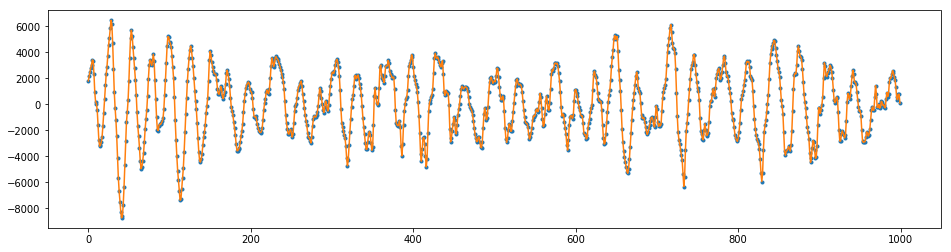

In [10]:
#zoomed  view of wave
plt.figure(figsize=(16, 4))
plt.plot(data[8000:9000], '.'); plt.plot(data[8000:9000], '-');

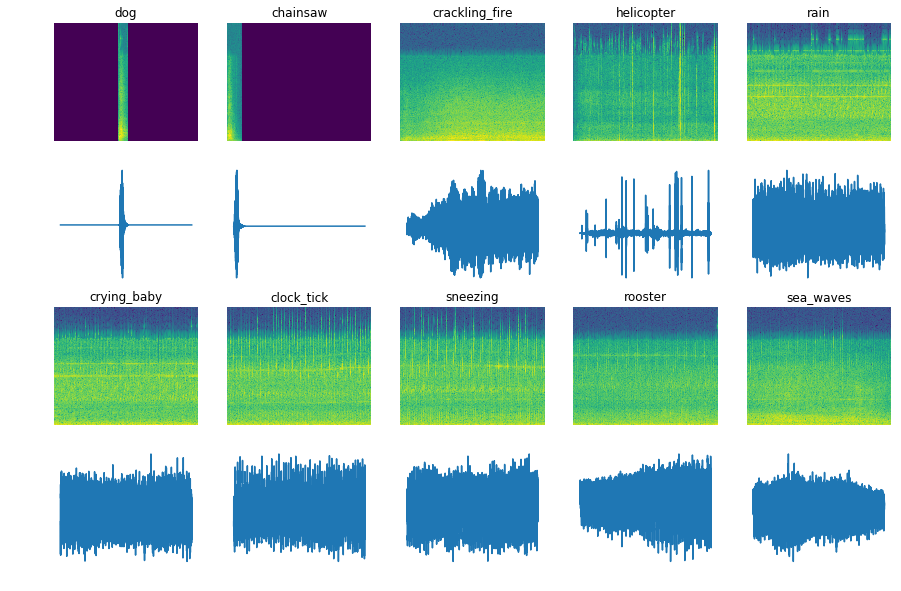

In [11]:
#visualisation of a sample from each category
import scipy
from scipy import signal

classes=['dog', 'chainsaw', 'crackling_fire', 'helicopter', 'rain',
       'crying_baby', 'clock_tick', 'sneezing', 'rooster', 'sea_waves']
filename=['1-100032-A-0.wav','1-116765-A-41.wav','5-215658-A-12.wav','1-172649-F-40.wav','1-17367-A-10.wav'
         '1-22694-A-20.wav','5-235671-A-38.wav','5-221593-A-21.wav','5-233160-A-1.wav','5-219379-C-11.wav']
z=[]
for i in train.filename:
    fname = "../Environment sound classification/audio/" + i
    rate, data = wavfile.read(fname)
    z.append(data)
    
fig, axs = plt.subplots(4, 5, figsize=(15, 10))
for idx in range(10):
    i, j = int(idx / 5), int(idx % 5)
    sampleFreqs, segmentTimes, sxx = signal.spectrogram(z[idx], 44100)
    axs[i*2][j].pcolormesh((len(segmentTimes) * segmentTimes / segmentTimes[-1]),
                         sampleFreqs,
                         10 * np.log10(sxx + 1e-15))
    axs[i*2][j].set_title(classes[idx])
    axs[i*2][j].set_axis_off()
    axs[i*2+1][j].plot(z[idx])
    axs[i*2+1][j].set_axis_off()
    
plt.show()

In [12]:
#extracting features from a wave
import librosa
SAMPLE_RATE = 44100
fname = "../Environment sound classification/audio/" + '5-234879-A-1.wav'  
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

<function matplotlib.pyplot.show(*args, **kw)>

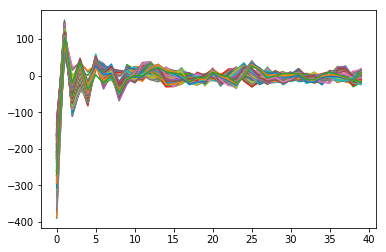

In [13]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
plt.plot(mfcc)
plt.show

In [14]:
# extract features from the data for train and test set..
SAMPLE_RATE = 44100
def parser(row):
    file_name = "../Environment sound classification/audio/" + row['filename']  
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=SAMPLE_RATE, n_mfcc=40).T,axis=0) 
    feature = mfccs
    label = row.category
    return [feature, label]

In [15]:
temp = train.apply(parser, axis=1)

In [16]:
temp.head()

0    [[-640.8436643679569, 1.134502993911934, -11.0...
1    [[-621.2222537499724, 9.079818099910447, -5.86...
2    [[-90.84159025744545, 74.09350068887156, -64.3...
3    [[-304.63885706707066, 85.05187067270415, 19.3...
4    [[-43.705716738394095, 64.96879863821263, 47.0...
dtype: object

In [17]:
a=[]
for i in train.index:
    a.append(temp[i][0])
x=np.array(a)

In [18]:
b=[]
for i in train.index:
    b.append(temp[i][1])
y=np.array(b)

In [19]:
train_x=x[:320]
train_y=y[0:320]
test_x=x[320:400]
test_y=y[320:400]

In [20]:
#training on svm 
import sklearn as sk
classifier_name = 'Support Vector Machine (SVM)'
svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
svm.fit(train_x,train_y)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=20150420, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
#Testing  
train_predictions = svm.predict(train_x)
train_acc = 100. * float(sum(train_predictions == train_y))/train_y.shape[0]
print ('Training accuracy = %0.2f%%' % train_acc)

test_predictions = svm.predict(test_x)
test_acc = 100. * float(sum(test_predictions == test_y))/test_y.shape[0]
print ('Test set accuracy = %0.2f%%' % test_acc)

Training accuracy = 100.00%
Test set accuracy = 67.50%


In [22]:
#prediction on a sample outside of dataset
import librosa
SAMPLE_RATE = 44100
file_name = "../Environment sound classification/" + 'bark.wav'  
X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=SAMPLE_RATE, n_mfcc=40).T,axis=0)

In [23]:
# play a sample from sound data 
import IPython.display as ipd  
fname = "../Environment sound classification/" + 'bark.wav'
ipd.Audio(fname)

In [24]:
b = np.zeros((1,len(mfccs)))
for i in range(0,len(mfccs)):
    b[0,i]=mfccs[i]
svm.predict(b)

array(['dog'], dtype='<U14')